In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/image_tensors.zip"
extract_path = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import os
import torch
from torch.utils.data import Dataset


class PTImageFlatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for fname in os.listdir(root_dir):
            if fname.endswith(".pt"):
                path = os.path.join(root_dir, fname)
                data = torch.load(path)
                label_str = data['label']
                self.samples.append((path, label_str))

        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set([s[1] for s in self.samples])))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label_str = self.samples[idx]
        data = torch.load(path)
        tensor = data['tensor']  # shape: [3, 224, 224]
        label = self.label_to_idx[label_str]

        if self.transform:
            tensor = self.transform(tensor)

        return tensor.float(), label

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = PTImageFlatDataset('/content/data/image_tensors', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
for images, labels in dataloader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np



# Train / Test split (80/20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load the model
model_path = "/content/drive/MyDrive/resnet50_genre.pth" # Replace with the actual path to your model file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model = models.resnet50(num_classes=10)

# Load the saved state dictionary into the model
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

model.eval() # Set the model to evaluation mode # Now this line should work

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# prompt: freeze all layers of the model except the final fully connected layer, do a shallow transfer learning on the model using train loader and test loader (showing the train/test accuracy, train/test loss for each epoch)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_to_idx))  # Assuming dataset.label_to_idx contains all possible labels.

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # Only optimize the parameters of the final layer

# Number of epochs
num_epochs = 15

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss = train_loss / train_total


    # Evaluation loop
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_loss = test_loss / test_total


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/15], Train Loss: 3.1505, Train Accuracy: 6.65%, Test Loss: 2.9711, Test Accuracy: 15.00%
Epoch [2/15], Train Loss: 2.8893, Train Accuracy: 13.61%, Test Loss: 2.7408, Test Accuracy: 27.50%
Epoch [3/15], Train Loss: 2.7095, Train Accuracy: 25.00%, Test Loss: 2.6130, Test Accuracy: 31.25%
Epoch [4/15], Train Loss: 2.5654, Train Accuracy: 30.38%, Test Loss: 2.4672, Test Accuracy: 32.50%
Epoch [5/15], Train Loss: 2.4443, Train Accuracy: 35.44%, Test Loss: 2.3586, Test Accuracy: 38.75%
Epoch [6/15], Train Loss: 2.3321, Train Accuracy: 44.30%, Test Loss: 2.2941, Test Accuracy: 45.00%
Epoch [7/15], Train Loss: 2.2601, Train Accuracy: 44.94%, Test Loss: 2.2336, Test Accuracy: 40.00%
Epoch [8/15], Train Loss: 2.1780, Train Accuracy: 47.15%, Test Loss: 2.1702, Test Accuracy: 50.00%
Epoch [9/15], Train Loss: 2.1076, Train Accuracy: 46.52%, Test Loss: 2.1151, Test Accuracy: 51.25%
Epoch [10/15], Train Loss: 2.0291, Train Accuracy: 52.85%, Test Loss: 2.0635, Test Accuracy: 51.25%
Epoch [11/

In [ ]:
import matplotlib.pyplot as plt

train_L = [3.1505, 2.8893, 2.7095, 2.5654, 2.4443, 2.3321, 2.2601, 2.1780, 2.1076, 2.0291, 1.9634, 1.9277, 1.8618, 1.8275, 1.7842]
train_A = [6.65, 13.61, 25.00, 30.38, 35.44, 44.30, 44.94, 47.15, 46.52, 52.85, 55.38, 53.16, 56.65, 59.81, 58.23]

test_L = [2.9711, 2.7408, 2.6130, 2.4672, 2.3586, 2.2941, 2.2336, 2.1702, 2.1151, 2.0635, 2.0361, 1.9934, 1.9662, 1.9197, 1.8820]
test_A = [15.00, 27.50, 31.25, 32.50, 38.75, 45.00, 40.00, 50.00, 51.25, 51.25, 47.50, 50.00, 51.25, 55.00, 51.25]

In [ ]:
epoch = [x for x in range(1, 16)]
epoch

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

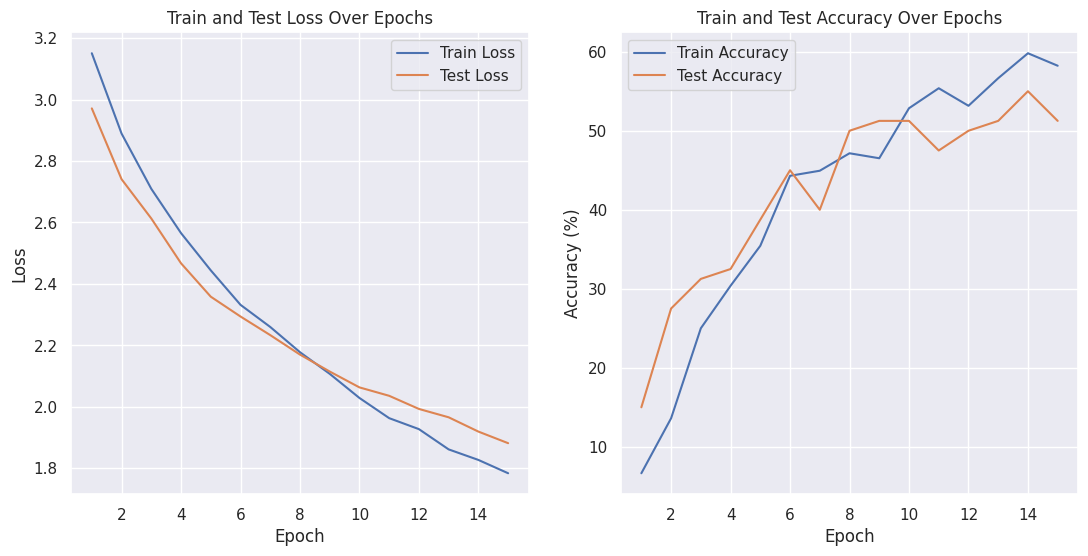

In [ ]:
import seaborn as sns

sns.set(font_scale=1)

plt.figure(figsize=(13, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch, train_L, label='Train Loss')
plt.plot(epoch, test_L, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch, train_A, label='Train Accuracy')
plt.plot(epoch, test_A, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy Over Epochs')
plt.legend()